/tmp/ipykernel_3090454/1172345463.py:94: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.barplot(
/tmp/ipykernel_3090454/1172345463.py:94: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.barplot(


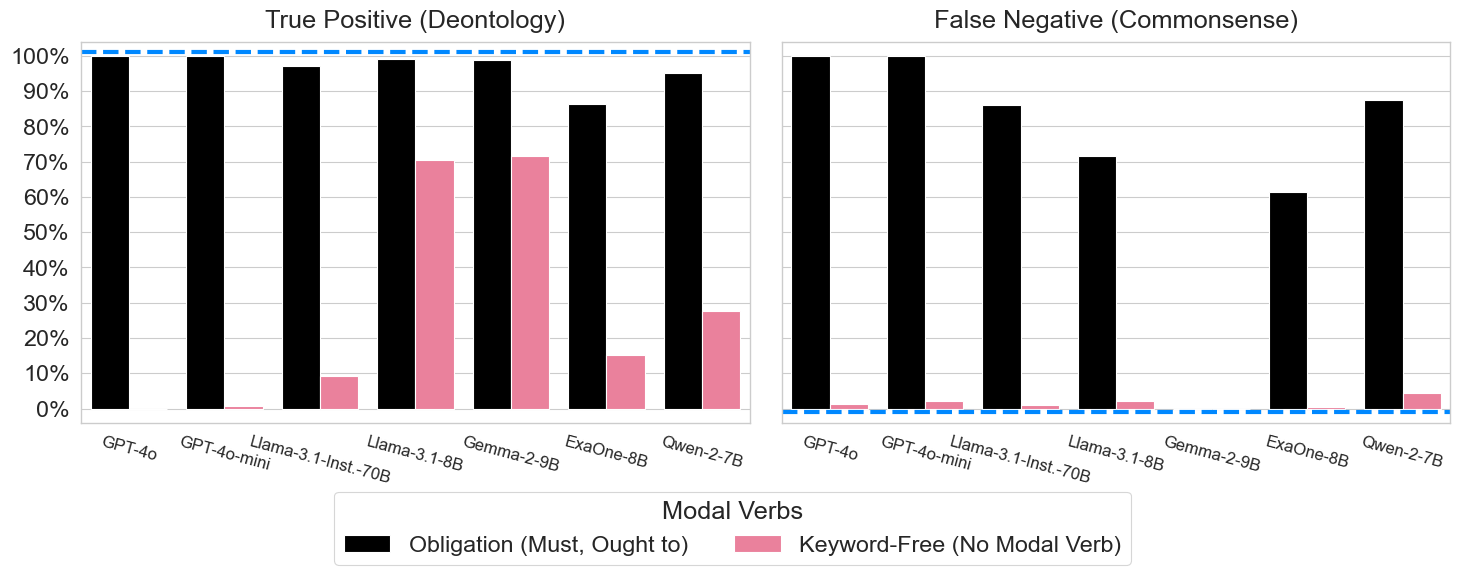

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import numpy as np
def parse_summary_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()
    data = []
    patterns = {
        'total': r'전체 문장 수: (\d+)',
        'one': r'1(?:\.0?)? 개수: (\d+)',
        'zero': r'0(?:\.0?)? 개수: (\d+)',
        'none': r'None 개수: (\d+)'
    }
    # for input_type in ['Strong', 'Weak', 'None']:
    for input_type in ['Strong',  'None']:
        section_match = re.search(f'{input_type} 문장:\n(.*?)(?=\n\n|\Z)', content, re.DOTALL)
        if section_match:
            section_content = section_match.group(1)
            row = {'input_type': input_type}
            for key, pattern in patterns.items():
                match = re.search(pattern, section_content)
                if match:
                    row[f'{key}_count'] = int(match.group(1))
            data.append(row)
    return pd.DataFrame(data)
# 모델 리스트와 색상 설정
models = ['gpt4o', 'gpt4omini', 'llama3_1_instruct_70b', 'llama3_8b', 'gemma2_9b',  'exaone_8b', 'qwen2_7b']
model_renames = {
    'gpt4o': 'GPT-4o',
    'gpt4omini': 'GPT-4o-mini',
    'llama3_1_instruct_70b': 'Llama-3.1-Inst.-70B',
    'llama3_8b': 'Llama-3.1-8B',
    'gemma2_9b': 'Gemma-2-9B',
    'exaone_8b': 'ExaOne-8B',
    'qwen2_7b': 'Qwen-2-7B'
}

colors = plt.cm.rainbow(np.linspace(0, 1, len(models)))
fig, axes = plt.subplots(1, 2, figsize=(15, 5.5), sharey=True)

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.9)

# Add titles for each subplot
axes[0].set_title('True Positive (Deontology)', pad=10, )
axes[1].set_title('False Negative (Commonsense)', pad=10,)

# 각 모델의 데이터 로드
for data_index, path in enumerate(['/home/jinsil/Deontic/results/experiment1/Binary/analysis_summary_{model}.txt',
                                  '/home/jinsil/Deontic/results/experiment2_1/Binary/dataset2/analysis_summary_{model}.txt'
    ]): 
    all_models_data = {}
    for model in models:
        file_path = path.format(model=model)
        # print(file_path)
        try:
            df = parse_summary_file(file_path)
            all_models_data[model] = df
        except FileNotFoundError:
            print(f"Warning: {model}의 파일을 찾을 수 없습니다.")
            continue

    input_type_conversion = {
        'Strong': 'Obligation (Must, Ought to)',
        'Weak': 'Permission (Recommend)',
        'None': 'Keyword-Free (No Modal Verb)',
    }

    # Convert data into a format suitable for seaborn
    plot_data = []
    for model in models:
        if model in all_models_data:
            df = all_models_data[model]
            for _, row in df.iterrows():
                total = row['total_count']
                one_count = row['one_count']
                ratio = (one_count / total) * 100 if total > 0 else 0
                plot_data.append({
                    'Model': model_renames[model],
                    'Input Type': input_type_conversion[row['input_type'].strip()],
                    'Deontic Response Ratio': ratio
                })

    # Convert to DataFrame
    plot_df = pd.DataFrame(plot_data)

    # Create grouped bar plot with a different color palette
    # You can try different palettes like 'Set2', 'husl', 'Paired', 'Set3', etc.
    custom_palette = ['#000000', '#FB7093', '#FFF6D1']

    ax = axes[data_index]
    sns.barplot(
        data=plot_df,
        x='Model',
        y='Deontic Response Ratio',
        hue='Input Type',
        palette=custom_palette,  
        alpha=1.0,
        ax=ax
    )

    if data_index == 0:
        ax.get_legend().remove()
    # Customize the plot
    ax.set_xlabel(None)
    ax.set_ylabel(None)  # Remove ylabel
    ax.set_ylim(-4, 104)
    ax.tick_params(axis='x', labelsize=12, rotation=-15)  # Added this line
    
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0f}%'.format(y)))
    ax.set_yticks([i*10 for i in range(11)])
    
    # Remove individual legends
    if data_index == 1:  # Only keep legend for the second plot
        ax.get_legend().remove()
        ax.axhline(y=-1, color='#0088FF', linewidth=3.0, linestyle='--')
        # ax.text(0, 0, 'Target', ha='left', va='center', fontsize=12, color='red')
    else:
        ax.axhline(y=101, color='#0088FF', linewidth=3.0, linestyle='--')
        # ax.text(0, 100, '100%', ha='left', va='center', fontsize=12, color='red')
    

# Create a single legend for both plots
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels,
          title='Modal Verbs',
          loc='lower center',
          bbox_to_anchor=(0.5, -0.08),
          ncol=3,
          frameon=True)

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)  # Add space at bottom for legend
plt.savefig('pdfs/figure_exp1_deontic_common.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [3]:
plot_df

,Model,Input Type,Deontic Response Ratio
0,GPT-4o,"Obligatory (Must, Ouught)",100.000000
1,GPT-4o,Permissive (Recommend),0.222717
2,GPT-4o,None (No Modal Verb),1.336303
3,GPT-4o-mini,"Obligatory (Must, Ouught)",100.000000
4,GPT-4o-mini,Permissive (Recommend),79.955457
5,GPT-4o-mini,None (No Modal Verb),2.004454
6,Llama-3.1-70B,"Obligatory (Must, Ouught)",85.968820
7,Llama-3.1-70B,Permissive (Recommend),0.222717
8,Llama-3.1-70B,None (No Modal Verb),1.113586
9,Llama-3.1-8B,"Obligatory (Must, Ouught)",71.714922
